**Applying RNN to Time-Series Data**

Taking weather forecasting data

In [1]:
!pip install tensorflow==2.15

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.1 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installation

In [2]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip      # Loading the data for applying RNN
!unzip jena_climate_2009_2016.csv.zip

--2024-11-03 18:28:13--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.42.240, 16.182.97.224, 52.216.42.80, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.42.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  5.71MB/s    in 2.3s    

2024-11-03 18:28:17 (5.71 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


Importing the dataset

In [3]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")  # This is the file

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)     # Printing the initial values
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [4]:
import numpy as np
temp = np.zeros((len(lines),))
pmry_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temp[i] = values[1]
    pmry_data[i, :] = values[:]

**Graph which shows the timeseries of temperatues as we took the weather forecasting dataset**

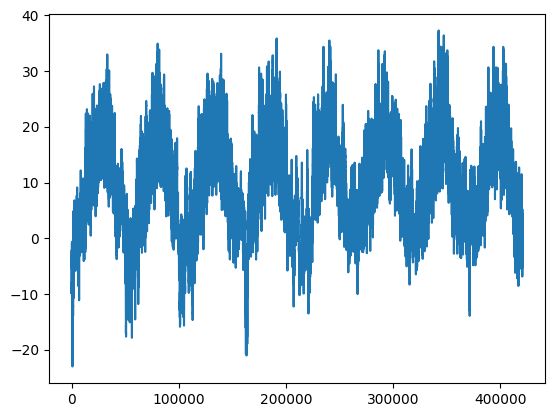

In [5]:
from matplotlib import pyplot as plt # Using matplotlib to plot the values
plt.plot(range(len(temp)), temp)

**Temperatues in °C**

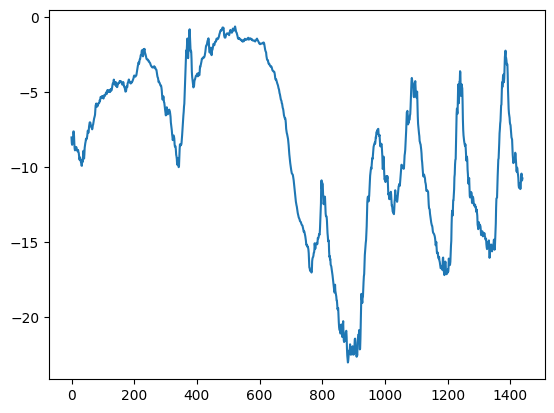

In [6]:
plt.plot(range(1440), temp[:1440])

**Calculating the quantity of samples that each data split will require**

In [7]:
num_train_samples = int(0.5 * len(pmry_data))
num_val_samples = int(0.25 * len(pmry_data))
num_test_samples = len(pmry_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


**Data Standardization**

Computing the mean and standard deviation on train data

In [8]:
mean = pmry_data[:num_train_samples].mean(axis=0)
pmry_data-= mean
std = pmry_data[:num_train_samples].std(axis=0)
pmry_data/= std

Here we use Numpy array to produce data sets in bulk for time series model training.

In [9]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dataset_1 = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],           # Taking input sequence of length 3
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dataset_1:     # Using for loop to iterate over batches of data
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Creating training, testing, and validation of datasets**

In [10]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    pmry_data[:-delay],
    targets=temp[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    pmry_data[:-delay],
    targets=temp[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    pmry_data[:-delay],
    targets=temp[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Shape of the data chunks**

In [11]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


**1st Model:**


---


***A common-sense, non-machine-learning baseline***

**Baseline MAE caluculation**

In [12]:
def evaluate_naive_method(dataset): # using evaluate_naive_method to calculate MAE
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}") # Displaying the validation MAE
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}") #  # Displaying the validation MAE

Validation MAE: 2.44
Test MAE: 2.62


**2nd Model:**


---


***Basic machine-learning model***

**Simple neural network model for forecasting using Keras.**

In [13]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, pmry_data.shape[-1])) # Defining the input layer of the model
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
# Specifying a callback list to be utilized in training.
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.x",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}") # Printing the MAE of test dataset

Epoch 1/5
819/819 [==============================] - 39s 45ms/step - loss: 11.8445 - mae: 2.6650 - val_loss: 11.6112 - val_mae: 2.6859
Epoch 2/5
819/819 [==============================] - 36s 43ms/step - loss: 8.7439 - mae: 2.3287 - val_loss: 12.6075 - val_mae: 2.7973
Epoch 3/5
819/819 [==============================] - 36s 43ms/step - loss: 8.0644 - mae: 2.2386 - val_loss: 9.8661 - val_mae: 2.4857
Epoch 4/5
819/819 [==============================] - 45s 55ms/step - loss: 7.6077 - mae: 2.1750 - val_loss: 11.0607 - val_mae: 2.6195
Epoch 5/5
405/405 [==============================] - 12s 29ms/step - loss: 11.4088 - mae: 2.6534
Test MAE: 2.65


The above model takes as input a sequence of data points and outputs a single value.

In [14]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, pmry_data.shape[-1])) # Defining the input layer of the model
x = layers.Flatten()(inputs)
x = layers.Dense(8, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
# Specifying a callback list to be utilized in training.
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.x",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}") # Printing the MAE of test dataset

Epoch 1/5
819/819 [==============================] - 46s 54ms/step - loss: 12.4833 - mae: 2.7337 - val_loss: 11.4946 - val_mae: 2.6857
Epoch 2/5
819/819 [==============================] - 45s 54ms/step - loss: 9.1430 - mae: 2.3767 - val_loss: 11.5156 - val_mae: 2.6873
Epoch 3/5
819/819 [==============================] - 34s 41ms/step - loss: 8.6697 - mae: 2.3189 - val_loss: 11.2399 - val_mae: 2.6429
Epoch 4/5
819/819 [==============================] - 37s 45ms/step - loss: 8.4335 - mae: 2.2848 - val_loss: 10.2721 - val_mae: 2.5216
Epoch 5/5
405/405 [==============================] - 12s 29ms/step - loss: 11.4536 - mae: 2.6719
Test MAE: 2.67


In [15]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, pmry_data.shape[-1])) # Defining the input layer of the model
x = layers.Flatten()(inputs)
x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
# Specifying a callback list to be utilized in training.
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.x",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}") # Printing the MAE of test dataset

Epoch 1/5
819/819 [==============================] - 46s 56ms/step - loss: 12.1126 - mae: 2.7012 - val_loss: 12.1827 - val_mae: 2.7758
Epoch 2/5
819/819 [==============================] - 36s 44ms/step - loss: 8.7022 - mae: 2.3138 - val_loss: 10.0616 - val_mae: 2.5021
Epoch 3/5
819/819 [==============================] - 35s 42ms/step - loss: 7.7671 - mae: 2.1879 - val_loss: 10.0216 - val_mae: 2.4997
Epoch 4/5
819/819 [==============================] - 36s 44ms/step - loss: 7.1493 - mae: 2.0981 - val_loss: 11.6849 - val_mae: 2.7163
Epoch 5/5
405/405 [==============================] - 12s 29ms/step - loss: 11.0773 - mae: 2.6145
Test MAE: 2.61


In [16]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, pmry_data.shape[-1])) # Defining the input layer of the model
x = layers.Flatten()(inputs)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
# Specifying a callback list to be utilized in training.
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.x",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}") # Printing the MAE of test dataset

Epoch 1/5
819/819 [==============================] - 46s 55ms/step - loss: 12.6189 - mae: 2.7548 - val_loss: 12.4114 - val_mae: 2.7799
Epoch 2/5
819/819 [==============================] - 35s 42ms/step - loss: 8.5507 - mae: 2.2966 - val_loss: 11.6322 - val_mae: 2.6929
Epoch 3/5
819/819 [==============================] - 45s 55ms/step - loss: 7.4257 - mae: 2.1436 - val_loss: 11.0288 - val_mae: 2.6156
Epoch 4/5
819/819 [==============================] - 35s 42ms/step - loss: 6.7123 - mae: 2.0388 - val_loss: 10.5365 - val_mae: 2.5505
Epoch 5/5
405/405 [==============================] - 12s 28ms/step - loss: 11.5998 - mae: 2.6972
Test MAE: 2.70


Tried various dense units of 8, 32 and 64

**Graph of Training and Validation MAE Values**

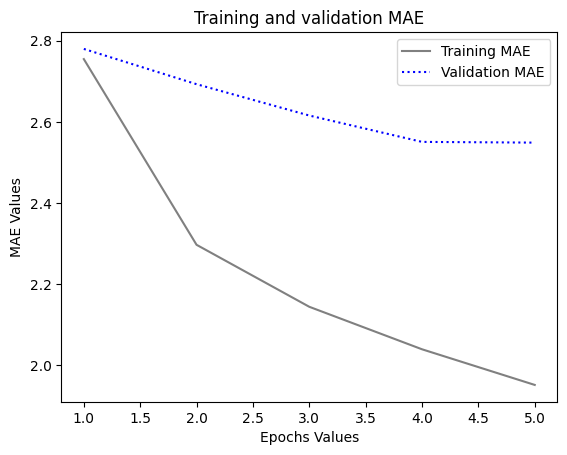

In [17]:
# matplotlib.pyplot for creating plots
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="solid", label="Training MAE")
plt.plot(epochs, val_loss, color="blue", linestyle="dotted", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs Values")
plt.ylabel("MAE Values")
plt.legend()
plt.show()

**3rd Model:**


---



***1D convolutional model***

In [18]:
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(sequence_length, pmry_data.shape[-1]))
convol_x = layers.Conv1D(8, 24, activation="relu")(inputs)     # 1D conventional layer
convol_x = layers.MaxPooling1D(2)(convol_x)                    # Max pooling Layer
convol_x = layers.Conv1D(8, 12, activation="relu")(convol_x)   # 1D conventional layer
convol_x = layers.MaxPooling1D(2)(convol_x)                    # Max pooling Layer
convol_x = layers.Conv1D(8, 6, activation="relu")(convol_x)    # 1D conventional layer
convol_x = layers.GlobalAveragePooling1D()(convol_x)
outputs = layers.Dense(1)(convol_x)
model = keras.Model(inputs, outputs)
# Specifying a callback list to be utilized in training.
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.convol_x",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.convol_x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}") # Printing the MAE of test dataset

Epoch 1/5
819/819 [==============================] - 41s 47ms/step - loss: 20.9132 - mae: 3.5715 - val_loss: 16.5360 - val_mae: 3.2442
Epoch 2/5
819/819 [==============================] - 47s 57ms/step - loss: 15.2478 - mae: 3.0966 - val_loss: 14.9986 - val_mae: 3.0767
Epoch 3/5
819/819 [==============================] - 47s 57ms/step - loss: 14.0312 - mae: 2.9626 - val_loss: 14.4348 - val_mae: 3.0059
Epoch 4/5
819/819 [==============================] - 37s 45ms/step - loss: 13.1436 - mae: 2.8618 - val_loss: 13.5962 - val_mae: 2.9155
Epoch 5/5
405/405 [==============================] - 13s 31ms/step - loss: 15.3323 - mae: 3.0969
Test MAE: 3.10


We received

Validation MAE: 3.2278

Test MAE      : 3.20

**Graph of Training and Validation MAE Values**

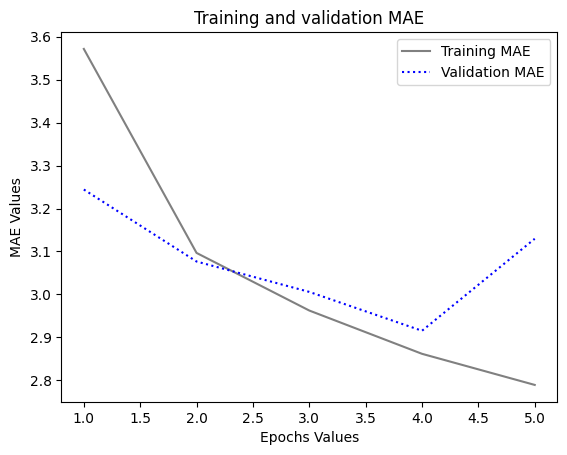

In [19]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="solid", label="Training MAE")
plt.plot(epochs, val_loss, color="blue", linestyle="dotted", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs Values")
plt.ylabel("MAE Values")
plt.legend()
plt.show()

The first recurrent baseline

**4th Model:**


---



***Simple LSTM-based model***

In [20]:
inputs = keras.Input(shape=(sequence_length, pmry_data.shape[-1])) # Defining the input layer of the model
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
# Specifying a callback list to be utilized in training.
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.x",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 45s 52ms/step - loss: 44.6314 - mae: 4.8932 - val_loss: 13.1842 - val_mae: 2.7422
Epoch 2/5
819/819 [==============================] - 51s 62ms/step - loss: 11.1848 - mae: 2.5919 - val_loss: 10.2911 - val_mae: 2.4694
Epoch 3/5
819/819 [==============================] - 41s 50ms/step - loss: 9.8322 - mae: 2.4482 - val_loss: 9.6106 - val_mae: 2.4032
Epoch 4/5
819/819 [==============================] - 38s 46ms/step - loss: 9.4075 - mae: 2.3968 - val_loss: 10.3863 - val_mae: 2.4669
Epoch 5/5
405/405 [==============================] - 13s 29ms/step - loss: 10.7749 - mae: 2.5791
Test MAE: 2.58


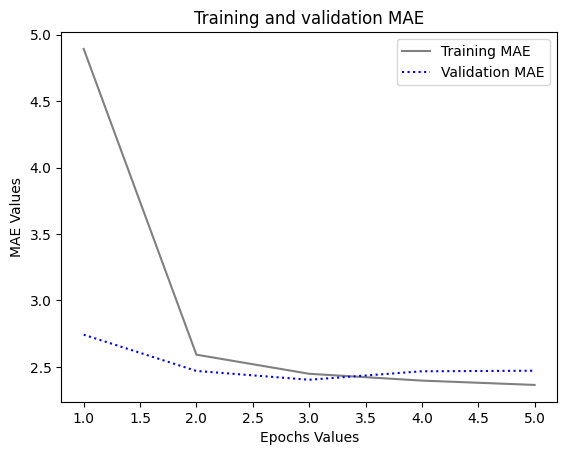

In [21]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="solid", label="Training MAE")
plt.plot(epochs, val_loss, color="blue", linestyle="dotted", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs Values")
plt.ylabel("MAE Values")
plt.legend()
plt.show()

**5th Model:**


---



***Recurrent neural networks***

**Apllying Numpy to a simple RNN**

In [22]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

In [23]:
num_features = 14  # Recurring network processing sequences of length
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

**RNN layer returning output shape**

In [24]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


In [25]:
num_features = 14  # Full output sequence retrieval from an RNN layer
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


**Stacking Of Recurring Neural Network**

In [26]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

**6th Model:**


---


***Recurring Neural Network(LSTM Layers)***

***Using recurrent dropout***

**Computing the dropout-regularized LSTM**

In [27]:
inputs = keras.Input(shape=(sequence_length, pmry_data.shape[-1]))              # Defining the input layer of the model
lstm_x = layers.LSTM(16, recurrent_dropout=0.25)(inputs)
lstm_x = layers.Dropout(0.5)(lstm_x)  # Using droput function
outputs = layers.Dense(1)(lstm_x)
model = keras.Model(inputs, outputs)
# Specifying a callback list to be utilized in training.
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.lstm_x",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_lstm_dropout.lstm_x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}") # Printing the Test sample MAE

Epoch 1/5
819/819 [==============================] - 284s 343ms/step - loss: 52.5900 - mae: 5.4103 - val_loss: 14.5471 - val_mae: 2.8581
Epoch 2/5
819/819 [==============================] - 301s 367ms/step - loss: 20.1168 - mae: 3.4435 - val_loss: 9.9612 - val_mae: 2.4485
Epoch 3/5
819/819 [==============================] - 286s 349ms/step - loss: 18.2298 - mae: 3.2831 - val_loss: 9.4529 - val_mae: 2.3995
Epoch 4/5
819/819 [==============================] - 302s 368ms/step - loss: 17.3799 - mae: 3.2004 - val_loss: 9.2659 - val_mae: 2.3767
Epoch 5/5
819/819 [==============================] - 299s 365ms/step - loss: 16.6924 - mae: 3.1423 - val_loss: 9.1370 - val_mae: 2.3535


405/405 [==============================] - 28s 67ms/step - loss: 10.7205 - mae: 2.5710
Test MAE: 2.57


 **Graph of dropout-regularized LSTM displaying the validation and training MAE**

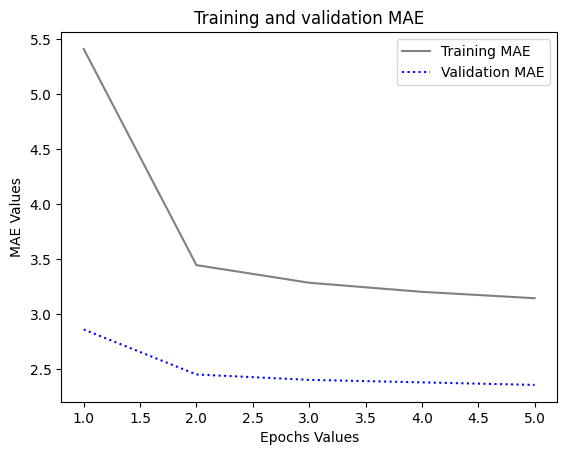

In [28]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="solid", label="Training MAE")
plt.plot(epochs, val_loss, color="blue", linestyle="dotted", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs Values")
plt.ylabel("MAE Values")
plt.legend()
plt.show()

In [29]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(16, recurrent_dropout=0.2, unroll=True)(inputs) # Using the LSTM

**7th Model:**


---



***Stacked setup of recurrent layers***

**Computing dropout-regularized, stacked GRU model**

In [30]:
inputs = keras.Input(shape=(sequence_length, pmry_data.shape[-1]))      # Defining the input layer of the model
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
# Specifying a callback list to be utilized in training.
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.x",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")  # Printing the MAE for test dataset

Epoch 1/5
819/819 [==============================] - 539s 654ms/step - loss: 26.4094 - mae: 3.7808 - val_loss: 9.4544 - val_mae: 2.3775
Epoch 2/5
819/819 [==============================] - 526s 642ms/step - loss: 14.0067 - mae: 2.9038 - val_loss: 9.2699 - val_mae: 2.3615
Epoch 3/5
819/819 [==============================] - 523s 638ms/step - loss: 13.1691 - mae: 2.8136 - val_loss: 8.9237 - val_mae: 2.3114
Epoch 4/5
819/819 [==============================] - 525s 641ms/step - loss: 12.5635 - mae: 2.7525 - val_loss: 9.2443 - val_mae: 2.3619
Epoch 5/5
819/819 [==============================] - 519s 633ms/step - loss: 12.0844 - mae: 2.6980 - val_loss: 8.9504 - val_mae: 2.3157


405/405 [==============================] - 38s 93ms/step - loss: 10.0277 - mae: 2.4829
Test MAE: 2.48


**8th Model:**


---


***Bidirectional RNN***

**Computing the Bidirectional LSTM**

In [35]:
inputs = keras.Input(shape=(sequence_length, pmry_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)                    # Using the Bidirectional function for the model
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset)
test_mae = model.evaluate(test_dataset)[1]
print(f"Test MAE: {test_mae:.2f}")    # Printing The Testing dataset MAE

Epoch 1/5
819/819 [==============================] - 49s 56ms/step - loss: 27.4845 - mae: 3.7718 - val_loss: 10.6784 - val_mae: 2.5260
Epoch 2/5
819/819 [==============================] - 41s 50ms/step - loss: 9.6254 - mae: 2.4243 - val_loss: 9.4611 - val_mae: 2.3716
Epoch 3/5
819/819 [==============================] - 41s 50ms/step - loss: 8.8245 - mae: 2.3149 - val_loss: 9.9585 - val_mae: 2.4324
Epoch 4/5
819/819 [==============================] - 41s 50ms/step - loss: 8.3881 - mae: 2.2573 - val_loss: 9.8602 - val_mae: 2.4097
Epoch 5/5
405/405 [==============================] - 13s 31ms/step - loss: 9.9979 - mae: 2.4699
Test MAE: 2.47


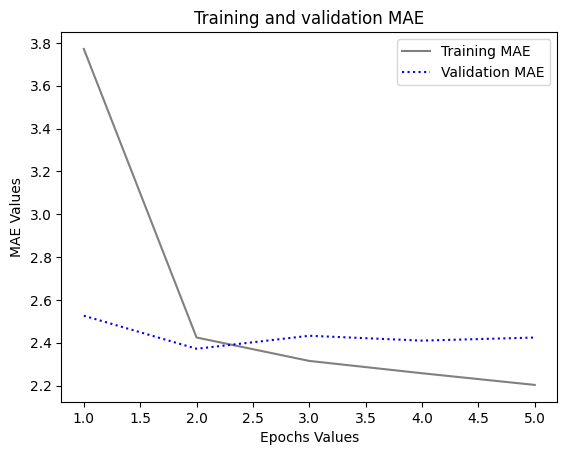

In [36]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="solid", label="Training MAE")
plt.plot(epochs, val_loss, color="blue", linestyle="dotted", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs Values")
plt.ylabel("MAE Values")
plt.legend()
plt.show()

**9th Model:**


---


***Combination Of 1D convent and dropout-regularized LSTM***

In [37]:
mix_1d_RNN = layers.concatenate([convol_x, lstm_x]) # Using 1D convent and RNN
outputs = layers.Dense(1)(mix_1d_RNN)
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=5, validation_data=val_dataset)
test_mae = model.evaluate(test_dataset)[1]
print(f"Test MAE: {test_mae:.2f}") # Printing the Testing MAE

Epoch 1/5
819/819 [==============================] - 46s 51ms/step - loss: 7.6588 - mae: 2.1592 - val_loss: 10.0146 - val_mae: 2.4399
Epoch 2/5
819/819 [==============================] - 41s 50ms/step - loss: 7.4183 - mae: 2.1204 - val_loss: 10.0476 - val_mae: 2.4499
Epoch 3/5
819/819 [==============================] - 41s 50ms/step - loss: 7.1914 - mae: 2.0867 - val_loss: 10.3178 - val_mae: 2.4722
Epoch 4/5
819/819 [==============================] - 41s 50ms/step - loss: 6.9492 - mae: 2.0533 - val_loss: 10.5569 - val_mae: 2.4898
Epoch 5/5
405/405 [==============================] - 13s 31ms/step - loss: 10.8174 - mae: 2.5732
Test MAE: 2.57


**Graph of Training and Validation MAE of the combination of 1D Convent and RNN**

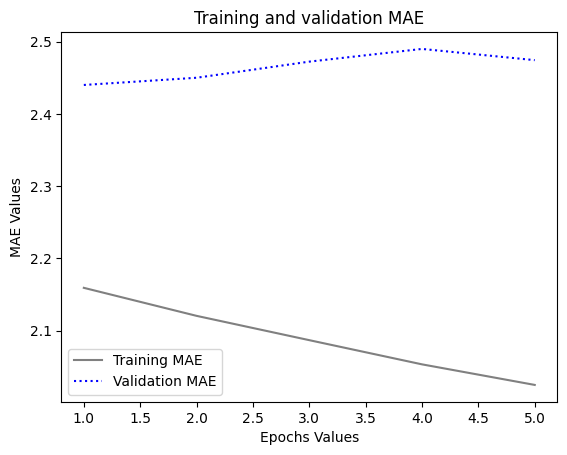

In [38]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="solid", label="Training MAE")
plt.plot(epochs, val_loss, color="blue", linestyle="dotted", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs Values")
plt.ylabel("MAE Values")
plt.legend()
plt.show()

Built 14 models: Following are the details;

Model 1: common-sense, non-machine-learning baseline

Model 2: A basic machine-learning model

Model 3: 1D convolutional model

Model 4: Simple RNN layer that can process sequences of any length

Model 5: Simple RNN - Stacking RNN layers

Model 6: A Simple GRU (Gated Recurrent Unit)

Model 7: LSTM-Simple

Model 8: LSTM - dropout Regularization

Model 9: Stacked setup with 16 units

Model 10: Stacked setup with 32 units

Model 11: Stacked setup with 8 units

Model 12: LSTM - dropout-regularized, stacked

Model 13: Bidirectional LSTM

Model 14: 1D Convnets and LSTM togther

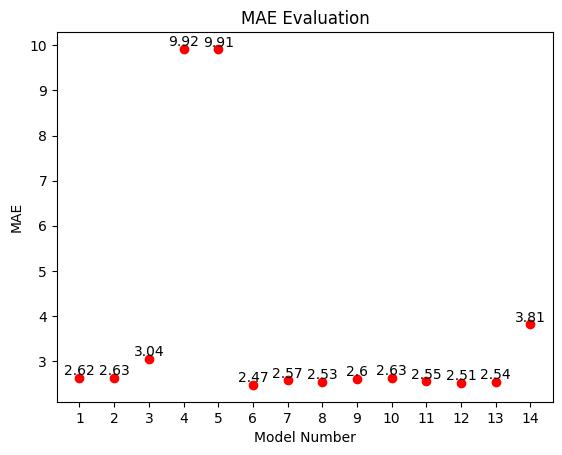

In [39]:
Models = ("1","2","3","4","5","6","7","8","9","10","11","12","13","14")
Mae = (2.62,2.63,3.04,9.92,9.91,2.47,2.57,2.53,2.60,2.63,2.55,2.51,2.54,3.81)

# MAE Evaluation
plt.scatter(Models, Mae, color="red")
plt.title("MAE Evaluation")
plt.xlabel("Model Number")
plt.ylabel("MAE")

for (xi, yi) in zip(Models,Mae):
    plt.text(xi, yi, yi, va='bottom', ha='center')

plt.show()